# ちょっぴりDD事前準備

事前準備を行います。

## データ準備

とりあえず作成したbrave.csvとmonster.csvをデータ分析に使える形にする

事前にS3バケットを作成しておく必要がある。さらに、SageMakerのIAMロールに適切な権限を付与する必要がある。

In [1]:
import pandas as pd
import numpy as np
import random
import boto3
from boto3.session import Session
import json
import decimal

In [2]:
# 勇者データ
brave_path = './data/brave.csv'
braves = pd.read_csv(brave_path, header=0)
braves.head()

,id,name,sex,age,attack
0,1,ImamuraYoshimi,女,39,950
1,2,KanayaNene,女,46,200
2,3,SumidaRui,男,17,953
3,4,FukuzawaMiu,女,57,861
4,5,AmemiyaMitsuo,男,54,834


In [3]:
monster_path = './data/monster.csv'
monsters = pd.read_csv(monster_path, header=0)
monsters = monsters.rename(columns={0: 'name'})
monsters.head()

,id,monster_name
0,1,スライム
1,2,ドラキー
2,3,スライムベス
3,4,ゴースト
4,5,モーモン


In [4]:
monsters['def'] = pd.Series( np.random.random( len(monsters))*100, index=monsters.index )
monsters.head()

,id,monster_name,def
0,1,スライム,58.604867
1,2,ドラキー,50.074730
2,3,スライムベス,94.040655
3,4,ゴースト,74.683292
4,5,モーモン,50.488852


In [5]:
train_output_path = './data/train.csv'

def calc_damage(bm):
    return (bm[4]/(bm[7]*bm[3]))*random.uniform(100, 120)

# 勇者からモンスターへの攻撃を想定した表を作る
## 学習用
tbl = pd.DataFrame( columns = ['braveid', 'bravename', 'bravesex', 'braveage', 'braveattack', 'monsterid', 'monstername', 'monsterdef', 'damage'])
for i in range(2000):
    brave_rand = random.randrange(len(braves))
    monster_rand = random.randrange(len(monsters))
    bm = np.concatenate([braves.loc[brave_rand], monsters.loc[monster_rand]], 0)
    tmp = pd.Series( np.append(bm, calc_damage(bm)), index=tbl.columns )
    tbl = tbl.append( tmp, ignore_index=True)
tbl.to_csv(train_output_path)

tbl.head()

,braveid,bravename,bravesex,braveage,braveattack,monsterid,monstername,monsterdef,damage
0,574,OkiYuuri,女,28,621,167,だいまどう,8.335544,277.081490
1,361,IwashitaSatoko,女,16,851,321,亡者のひとだま,18.347490,309.539097
2,142,NakajimaAi,女,38,50,351,ブラックチャック,97.717338,1.455323
3,199,FujisawaYumi,女,44,575,87,ひとくいばこ,22.811597,58.303182
4,1000,SuganoNaoko,女,27,922,118,ボーンナイト,9.428769,421.309164


In [6]:
# trainデータをdynamoDBに配置する
tablename = 'dddemo'
dynamodb = boto3.resource('dynamodb')

def create_table():
    table = dynamodb.create_table(
        TableName = tablename,
        KeySchema =[
            {
                'AttributeName' : 'id',
                'KeyType' : 'HASH'
            },
        ],
        AttributeDefinitions = [
            {
                'AttributeName' : 'id',
                'AttributeType' : 'S'
            },
        ],
        ProvisionedThroughput = {
            'ReadCapacityUnits' : 20,
            'WriteCapacityUnits' : 20
        }
    )
    table.meta.client.get_waiter('table_exists').wait(TableName = tablename)
    print (table.item_count)


create_table()

0


In [7]:
# dynamodb tableにデータを投入する
data = tbl.to_dict(orient='records')
table = dynamodb.Table(tablename)

with table.batch_writer() as batch:
    for idx, item in enumerate(data):
        # ここで、NaNが入っているkeyを落とします。nanのままだとエラーになります。
        item_not_has_nan = {key: item[key] for key in item if item[key] is not np.nan}
        item_decimal = json.loads(json.dumps(item_not_has_nan), parse_float=decimal.Decimal) # floatをdecimalにしないとエラー
        item_decimal['id'] = str(idx)
        #print(item_decimal)
        batch.put_item(Item=item_decimal)

In [8]:
# s3にデータを配置する
## 基礎編用、monster.csvをs3に配置する
bucket = 'dddemo-067150986393'
input_location = './data/monster.csv'
output_location = 'data/year=2021/monster.csv'

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket)
bucket.upload_file(input_location, output_location)

## ML編用の学習と推論エンドポイント

SageMakerでXGBoostを使ってダメージの学習を行う。  
ちゃんと学習させる時間がなかったのでかなり適当で、とりあえず学習が回ってエンドポイントが立つようにしただけです。  

In [2]:
# セットアップ
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker

print('Current SageMaker Python SDK Version ={0}'.format(sagemaker.__version__))

Current SageMaker Python SDK Version =2.41.0


In [3]:
damage = pd.read_csv('./data/train.csv')
damage.head()

,Unnamed: 0,braveid,bravename,bravesex,braveage,braveattack,monsterid,monstername,monsterdef,damage
0,0,574,OkiYuuri,女,28,621,167,だいまどう,8.335544,277.081490
1,1,361,IwashitaSatoko,女,16,851,321,亡者のひとだま,18.347490,309.539097
2,2,142,NakajimaAi,女,38,50,351,ブラックチャック,97.717338,1.455323
3,3,199,FujisawaYumi,女,44,575,87,ひとくいばこ,22.811597,58.303182
4,4,1000,SuganoNaoko,女,27,922,118,ボーンナイト,9.428769,421.309164


In [4]:
damage = damage.drop('bravename', axis=1)
damage = damage.drop('monstername', axis=1)
damage = damage.drop('Unnamed: 0', axis=1)
damage = damage.drop('bravesex', axis=1)
damage = damage.drop('monsterid', axis=1)

In [5]:
damage

,braveid,braveage,braveattack,monsterdef,damage
0,574,28,621,8.335544,277.081490
1,361,16,851,18.347490,309.539097
2,142,38,50,97.717338,1.455323
3,199,44,575,22.811597,58.303182
4,1000,27,922,9.428769,421.309164
...,...,...,...,...,...
1995,535,38,310,23.738759,34.896405
1996,170,32,695,9.731344,224.783623
1997,644,51,152,3.705725,87.477897
1998,580,23,897,84.550461,48.866356


In [6]:
model_data = pd.get_dummies(damage)
model_data

,braveid,braveage,braveattack,monsterdef,damage
0,574,28,621,8.335544,277.081490
1,361,16,851,18.347490,309.539097
2,142,38,50,97.717338,1.455323
3,199,44,575,22.811597,58.303182
4,1000,27,922,9.428769,421.309164
...,...,...,...,...,...
1995,535,38,310,23.738759,34.896405
1996,170,32,695,9.731344,224.783623
1997,644,51,152,3.705725,87.477897
1998,580,23,897,84.550461,48.866356


In [7]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

In [8]:
train_data

,braveid,braveage,braveattack,monsterdef,damage
36,364,32,457,95.377598,17.625889
729,379,55,455,72.382621,12.128455
1808,989,56,731,51.545997,26.538204
907,964,52,72,50.353833,2.828104
1685,248,38,228,92.095398,6.703968
...,...,...,...,...,...
278,212,24,595,70.918926,39.131924
678,320,53,918,66.762272,28.966916
822,227,31,267,85.292194,10.428881
1967,879,19,901,28.139254,188.700602


In [9]:
validation_data

,braveid,braveage,braveattack,monsterdef,damage
1055,420,52,32,8.393351,8.781936
474,558,26,637,83.538344,32.838165
1234,618,33,852,5.605802,547.359853
1760,473,19,228,99.333941,12.591460
1583,941,55,50,23.395019,4.135646
...,...,...,...,...,...
1408,277,24,286,40.023477,31.215166
402,151,46,336,70.784709,11.219605
1116,320,53,918,10.877656,186.091218
588,994,42,574,79.474022,18.552036


In [10]:
test_data

,braveid,braveage,braveattack,monsterdef,damage
977,72,55,38,15.811327,4.462525
1290,813,52,686,9.032342,162.560148
1362,808,55,211,87.184779,4.892592
1090,124,18,42,36.237572,6.822727
1445,62,35,499,90.295663,16.898114
...,...,...,...,...,...
1557,443,28,393,53.667324,30.277889
1573,166,58,253,57.124458,8.028601
1267,540,40,906,22.944632,100.839484
1126,546,18,955,53.667324,114.060154


In [11]:
!mkdir -p output
train_data.to_csv('./output/train.csv', header=False, index=False)
validation_data.to_csv('./output/validation.csv', header=False, index=False)

In [12]:
sagemaker_session = sagemaker.Session()
input_train = sagemaker_session.upload_data(path='./output/train.csv', key_prefix='sagemaker/DEMO-xgboost-damage')
input_validation = sagemaker_session.upload_data(path='./output/validation.csv', key_prefix='sagemaker/DEMO-xgboost-damage')

In [13]:
input_train

's3://sagemaker-us-east-1-067150986393/sagemaker/DEMO-xgboost-damage/train.csv'

In [14]:
# from sagemaker.session import s3_input
from sagemaker.inputs import TrainingInput

content_type='text/csv'
s3_input_train = TrainingInput(input_train, content_type=content_type)
s3_input_validation = TrainingInput(input_validation, content_type=content_type)

In [22]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

In [24]:
sess = sagemaker.Session()

hyperparameters = {"max_depth":"5",
                        "eta":"0.2",
                        "gamma":"4",
                        "min_child_weight":"6",
                        "subsample":"0.8",
                        "objective":"reg:linear", # 線形回帰
                        "num_round":"100"}

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    hyperparameters=hyperparameters,
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    sagemaker_session=sess)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-06-23 05:20:58 Starting - Starting the training job...
2021-06-23 05:21:21 Starting - Launching requested ML instancesProfilerReport-1624425657: InProgress
......
2021-06-23 05:22:21 Starting - Preparing the instances for training.........
2021-06-23 05:23:53 Downloading - Downloading input data...
2021-06-23 05:24:21 Training - Downloading the training image...
2021-06-23 05:24:55 Training - Training image download completed. Training in progress..[2021-06-23 05:24:57.809 ip-10-2-229-181.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined


2021-06-23 05:25:22 Uploading - Uploading generated training model
2021-06-23 05:25:22 Completed - Training job completed
Training seconds: 77
Billable seconds: 77


In [25]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------!

In [15]:
xgb_predictor = sagemaker.predictor.Predictor(endpoint_name='sagemaker-xgboost-2021-06-23-05-26-24-351')

In [16]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [17]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.values
predictions = []
predictions.append(predict(dtest[:, 1:]))
predictions = np.array(predictions).squeeze()

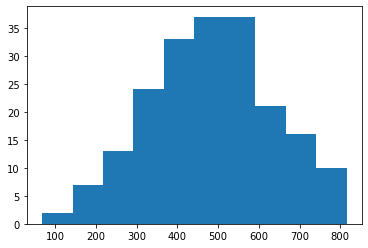

In [18]:
plt.hist(predictions)
plt.show()

In [19]:
predictions

array([775.40679932, 350.0211792 , 674.0355835 , 398.39642334,
       561.67669678, 706.95050049, 388.86819458, 354.62496948,
       394.96636963, 540.42712402, 517.45288086, 482.47399902,
       581.16992188, 174.1681366 , 628.95654297, 711.61242676,
       413.97363281, 334.79269409, 815.52502441, 546.55718994,
       192.24798584, 456.50494385, 396.54165649, 574.47076416,
       764.87127686, 569.7734375 , 406.63653564, 210.96405029,
       438.49316406, 648.69384766, 590.50665283, 736.39611816,
       663.99346924, 536.87432861, 407.34927368, 525.28063965,
       559.09576416, 442.02496338, 227.74732971, 471.62173462,
       585.07739258, 326.42611694, 214.4974823 , 573.14813232,
       478.39303589, 330.49371338, 478.871521  , 446.88671875,
       556.48126221, 390.5980835 , 516.85583496, 754.45153809,
       715.27319336, 374.40002441, 392.34976196, 431.77285767,
       359.27078247, 468.68411255, 635.61352539, 278.06604004,
       509.46875   , 369.61633301, 584.77661133, 555.93

In [20]:
print('\nEndpoint name (used by Athena): {}'.format(xgb_predictor.endpoint))

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



Endpoint name (used by Athena): sagemaker-xgboost-2021-06-23-05-26-24-351
